In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize
from HOTRG import get_lattice_size,get_dist_torus_2D,get_dist_2D
import matplotlib as mpl
import importlib
import correlation_ansatzs
importlib.reload(correlation_ansatzs)
from correlation_ansatzs import high_temp_correlation,low_temp_correlation,low_temp_correlation_1,low_temp_correlation_2,critical_correlation,loglog

%matplotlib inline

def process_data(data,log2Size=30):
    lattice_size=get_lattice_size(nLayers=2*log2Size,spacial_dim=2)
    data['x']=data.apply(lambda row:row['x1']-row['x0'],axis=1)
    data['y']=data.apply(lambda row:row['y1']-row['y0'],axis=1)
    data['dist']=data.apply(lambda row:get_dist_torus_2D(row['x'],row['y'],lattice_size),axis=1)
    data['theta']=data.apply(lambda row:np.arctan2(row['y'],row['x']),axis=1)
    data=data.sort_values(by=['dist'])
    return data

def fitWithHuberLoss(ansatz,x,y,p0=None,epsilon=1,
                             allow_positive_outliers=True,allow_negative_outliers=True):
    def loss(xs,ys,*p):
        dist=ys-ansatz(xs,*p)
        loss1=1/2 * dist**2 # lsq
        loss2=epsilon*(np.abs(dist)-epsilon/2) # huber
        if allow_positive_outliers:
            loss1[dist>epsilon]=loss2[dist>epsilon]
        if allow_negative_outliers:
            loss1[dist<-epsilon]=loss2[dist<-epsilon]
        return np.sum(loss1)
    xfit,yfit=x,y
    res=minimize(lambda p: loss(xfit,yfit,*p),p0,method='Nelder-Mead',tol=1e-6)
    p=res.x
    return p


def fit_data(data,ansatz,bias=None,cutoff_dist=None):
    data_slice=data[(data['correlation']>1e-2)].sort_values('dist')
    if cutoff_dist is not None:
        data_slice=data_slice[(data_slice['dist']<cutoff_dist)]
    dist,correlation=data_slice['dist'],data_slice['correlation']
    if bias is not None:
        correlation=np.abs(correlation-bias)
    logx,logy=np.log(dist),np.log(correlation)
    p,cov=curve_fit(loglog(ansatz),logx,logy,p0=ansatz.p0,maxfev=10000)
    p=fitWithHuberLoss(loglog(ansatz),logx,logy,p0=p,epsilon=0.1)
    cov=None
    print('fitted parameters:',p)
    print('fitted equation:',ansatz.eq.format(*p))
    return p,cov,ansatz






[GILT] Warning! float32 is not precise enough, leads to bad RG behavior
[GILT] Warning! float32 is not precise enough, leads to bad RG behavior


# correlation below, above and at the critical point

critical temperature
fitted parameters: [0.67689318 0.1280528 ]
fitted equation: 6.77e-01x^(-2 Δ),Δ=0.1281
high temperature
fitted parameters: [6.80194041e-01 1.99208819e+04 1.32271406e-01]
fitted equation: 6.80e-01e^(-x/ζ)/x^(2 Δ),ζ=1.99e+04,Δ=0.1323
low temperature
fitted parameters: [6.30430839e-01 2.67964854e+03 1.17719932e-01 5.48931238e-01]
fitted equation: 6.30e-01(ζ^(-1/B)+x^(-1/B))^(2 ∆ B),ζ=2.68e+03,∆=0.1177,B=0.5
with GILT


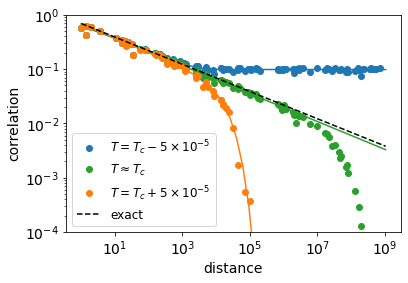

In [27]:

data1=pd.read_pickle('data/hotrg_gilt_X24_correlation.pkl')
data1=process_data(data1,log2Size=30)
print('\n# critical temperature')
p1,cov1,ansatz1=fit_data(data1,critical_correlation)
# p1,cov1,ansatz1=fit_data(data1['dist'],data1['correlation'],critical_correlation)

print('\n# high temperature')
data2=pd.read_pickle('data/hotrg_gilt_X24_lowB_correlation.pkl')
data2=process_data(data2,log2Size=30)
p2,cov2,ansatz2=fit_data(data2,high_temp_correlation)
# p2,cov2,ansatz2=fit_data(data2['dist'],data2['correlation'],high_temp_correlation)

print('\n#low temperature')
data3=pd.read_pickle('data/hotrg_gilt_X24_highB_correlation.pkl')
data3=process_data(data3,log2Size=30)
data3_obs=pd.read_csv('data/hotrg_gilt_X24_highB_observables.csv')
m02=data3_obs.iloc[-1]['magnetization']**2
p3,cov3,ansatz3=fit_data(data3,low_temp_correlation_2)
# p3,cov3,ansatz3=fit_data(data3['dist'],data3['correlation'],low_temp_correlation_2)
pexp=(0.69,0.125)

print('with GILT')

ls=np.geomspace(1,2**30)

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.plot(ls,ansatz3(ls,*p3),'-',color='tab:blue')
plt.plot(ls,ansatz1(ls,*p1),'-',color='tab:green')
plt.plot(ls,ansatz2(ls,*p2),'-',color='tab:orange')
plt.plot(data3['dist'],data3['correlation'],'o',label=r'$T=T_c-5\times10^{-5}$',color='tab:blue')
plt.plot(data1['dist'],data1['correlation'],'o',label=r'$T \approx T_c$',color='tab:green')
plt.plot(data2['dist'],data2['correlation'],'o',label=r'$T=T_c+5\times10^{-5}$',color='tab:orange')
plt.plot(ls,ansatz1(ls,*pexp),'--',color='black',label='exact')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
plt.ylim([1e-4,1])
plt.legend()
plt.show()



# comparison of different methods

- w and w/o gilt
- fix x0y0 or not

with GILT
fitted parameters: [0.67689318 0.1280528 ]
fitted equation: 6.77e-01x^(-2 Δ),Δ=0.1281
without GILT
fitted parameters: [0.69707343 0.12887387]
fitted equation: 6.97e-01x^(-2 Δ),Δ=0.1289
with GILT, 00
fitted parameters: [0.68716384 0.23396986]
fitted equation: 6.87e-01x^(-2 Δ),Δ=0.2340
without GILT, 00
fitted parameters: [0.70295341 0.11281545]
fitted equation: 7.03e-01x^(-2 Δ),Δ=0.1128


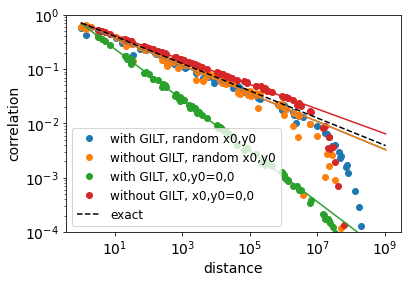

In [6]:
data1=pd.read_pickle('data/hotrg_gilt_X24_correlation.pkl')
data2=pd.read_pickle('data/hotrg_X24_correlation.pkl')
data3=pd.read_pickle('data/hotrg_gilt_X24_correlation_00.pkl')
data4=pd.read_pickle('data/hotrg_X24_correlation_00.pkl')


data1=process_data(data1,log2Size=30)
data2=process_data(data2,log2Size=30)
data3=process_data(data3,log2Size=30)
data4=process_data(data4,log2Size=30)


print('with GILT')
p1,cov1,ansatz1=fit_data(data1,critical_correlation)

print('without GILT')
p2,cov2,ansatz2=fit_data(data2,critical_correlation)

print('with GILT, 00')
p3,cov3,ansatz3=fit_data(data3,critical_correlation)

print('without GILT, 00')
p4,cov4,ansatz4=fit_data(data4,critical_correlation)

pexp=(0.71,0.125)

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})

ls=np.geomspace(1,2**30)

plt.plot(data1['dist'],data1['correlation'],'o',label='with GILT, random x0,y0',color='C0')
plt.plot(data2['dist'],data2['correlation'],'o',label='without GILT, random x0,y0',color='C1')
plt.plot(data3['dist'],data3['correlation'],'o',label='with GILT, x0,y0=0,0',color='C2')
plt.plot(data4['dist'],data4['correlation'],'o',label='without GILT, x0,y0=0,0',color='C3')

plt.plot(ls,ansatz1(ls,*p1),'-',color='C0')
plt.plot(ls,ansatz2(ls,*p2),'-',color='C1')
plt.plot(ls,ansatz3(ls,*p3),'-',color='C2')
plt.plot(ls,ansatz4(ls,*p4),'-',color='C3')
plt.plot(ls,ansatz4(ls,*pexp),'--',color='black',label='exact')



plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
plt.ylim([1e-4,1])
plt.legend()
plt.show()


# Comparison of two low temp ansatzs

m0^2= 0.09812237531317773
fitted bias: 0.09940423547995059
m0^2(fit)= 0.09940423547995059

# low_temp_correlation
fitted parameters: [6.09086611e-01 1.70737530e+03 1.70813537e-01 3.13860692e-01]
fitted equation: 6.09e-01e^(-x/ζ)/x^(2 Δ)+m0^2,ζ=1.71e+03,Δ=0.1708,m0=0.314
∆(x=1)= (∆+x/(2 ζ))/(1+m0^2/corr) = 0.14727363334231464
∆(approx)= 0.14318759525115032
zeta= 1707.3752988800738 (m0^2/A)^(-1/(2delta))= 207.00980106143467 (m0^2/A)^(-1/(2deltaCFT)) 1461.573922419491

# low_temp_correlation_2
fitted parameters: [6.79377057e-01 2.45102382e+03 1.23910350e-01 7.02862086e-01]
fitted equation: 6.79e-01(ζ^(-1/B)+x^(-1/B))^(2 ∆ B),ζ=2.45e+03,∆=0.1239,B=0.7

# high_temp_correlation, biased
bias= 0.09812237531317773 ,m_0=sqrt(bias)= 0.3132449126692686
fitted parameters: [6.07541273e-01 1.42976402e+03 1.67228842e-01]
fitted equation: 6.08e-01e^(-x/ζ)/x^(2 Δ),ζ=1.43e+03,Δ=0.1672
∆(x=1)= (∆+x/(2 ζ))/(1+m0^2/corr) = 0.14426275482499035

# high_temp_correlation, no biased
fitted parameters: [6.7532718

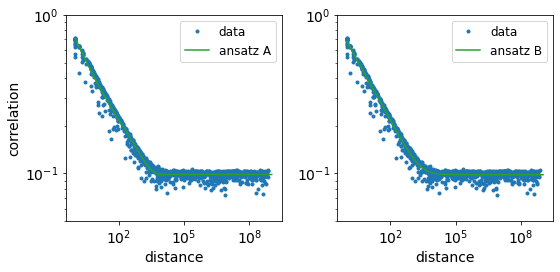

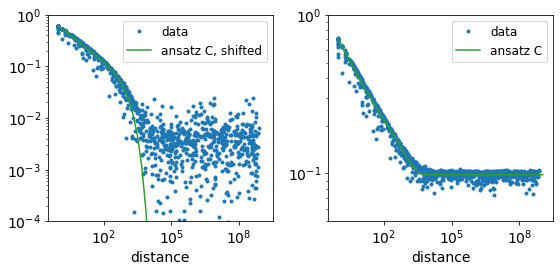

In [21]:
# compare low_temp_correlation and low_temp_correlation_1
importlib.reload(correlation_ansatzs)
from correlation_ansatzs import low_temp_correlation,low_temp_correlation_1,low_temp_correlation_2,low_temp_correlation_3,scale_dependent_delta
def get_bias(data,cutoff_dist):
    data_slice=data[(data['dist']>cutoff_dist)]
    bias=data_slice['correlation'].median()
    print('fitted bias:',bias)
    return bias




data1=pd.read_pickle('data/hotrg_gilt_X24_highB_correlation.pkl') # low temperature
data1=pd.concat([data1,pd.read_pickle('data/hotrg_gilt_X24_highB_correlation_appended.pkl')])
data1=process_data(data1,log2Size=30)
data1_obs=pd.read_csv('data/hotrg_gilt_X24_highB_observables.csv')
m02=data1_obs.iloc[-1]['magnetization']**2
print('m0^2=',m02)
m02_fit=get_bias(data1,cutoff_dist=10**5)
print('m0^2(fit)=',m02_fit)
bias=m02

print('\n# low_temp_correlation')
p1,cov1,ansatz1=fit_data(data1,low_temp_correlation)
A,zeta,delta,m0=p1
delta_1=scale_dependent_delta(1,A,zeta,delta,m0)
delta_2=delta*(1-m0**2/A)
print('∆(x=1)=',scale_dependent_delta.eq,'=',delta_1)
print('∆(approx)=',delta_2)

print('zeta=',zeta,'(m0^2/A)^(-1/(2delta))=',np.power(m0**2/A,-1/(2*delta)),'(m0^2/A)^(-1/(2deltaCFT))',np.power(m0**2/A,-1/(2*0.125)))
print('\n# low_temp_correlation_2')
p2,cov2,ansatz2=fit_data(data1,low_temp_correlation_2)

print('\n# high_temp_correlation, biased')
print('bias=',bias,',m_0=sqrt(bias)=',np.sqrt(bias))
p3,cov3,ansatz3=fit_data(data1,high_temp_correlation,bias=bias,cutoff_dist=10**3)
A,zeta,delta=p3
delta_1=scale_dependent_delta(1,A,zeta,delta,np.sqrt(bias))
print('∆(x=1)=',scale_dependent_delta.eq,'=',delta_1)

print('\n# high_temp_correlation, no biased')
fit_data(data1,high_temp_correlation,bias=0,cutoff_dist=10**3)


print('\n# critical_correlation, biased')
fit_data(data1,critical_correlation,bias=bias,cutoff_dist=10**3)
print('\n# critical_correlation, no biased')
fit_data(data1,critical_correlation,bias=0,cutoff_dist=10**3)

ls=np.geomspace(1,2**30)

plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.subplot(121)
plt.plot(data1['dist'],data1['correlation'],'.',label=r'data',color='tab:blue')
plt.plot(ls,ansatz1(ls,*p1),'-',color='tab:green',label='ansatz A')
plt.xscale('log');plt.yscale('log');plt.ylim([5e-2,1])
plt.xlabel('distance');plt.ylabel('correlation')
plt.legend()
plt.subplot(122)
plt.plot(data1['dist'],data1['correlation'],'.',label=r'data',color='tab:blue')
plt.plot(ls,ansatz2(ls,*p2),'-',color='tab:green',label='ansatz B')
plt.xscale('log');plt.yscale('log');plt.ylim([5e-2,1])
plt.xlabel('distance')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.subplot(121)
plt.plot(data1['dist'],np.abs(data1['correlation']-bias),'.',label=r'data',color='tab:blue')
plt.plot(ls,ansatz3(ls,*p3),'-',color='tab:green',label='ansatz C, shifted')
plt.xscale('log');plt.yscale('log');plt.ylim([1e-4,1])
plt.xlabel('distance')
plt.legend()
plt.subplot(122)
plt.plot(data1['dist'],data1['correlation'],'.',label=r'data',color='tab:blue')
plt.plot(ls,ansatz3(ls,*p3)+bias,'-',color='tab:green',label='ansatz C')
plt.xscale('log');plt.yscale('log');plt.ylim([5e-2,1])
plt.xlabel('distance')
plt.legend()
plt.tight_layout()
plt.show()
